# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [1]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

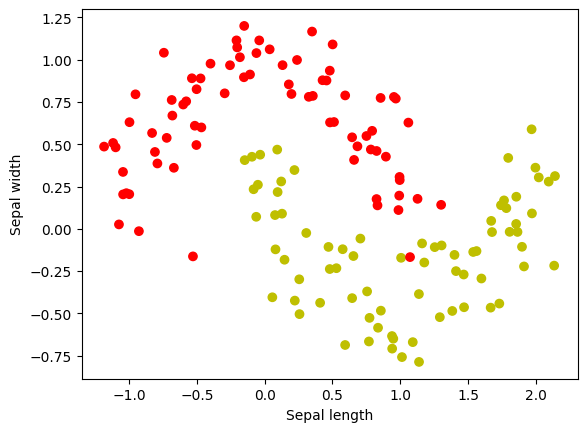

In [2]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [4]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [5]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [6]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [7]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.2645)


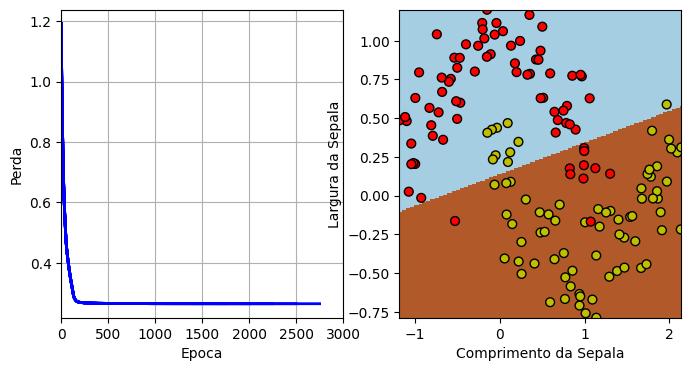

In [8]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [9]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 0.3637, -0.8328],
        [-0.2461,  0.1610],
        [ 0.1963, -0.7627],
        [-0.4124,  0.4267],
        [ 0.0027,  1.0412]])
dense.0.bias    torch.Size([5])
tensor([ 1.1496, -0.3701,  1.0216, -0.6668,  0.7579])
dense.2.weight  torch.Size([5, 5])
tensor([[-0.1974, -0.2101, -0.2208,  0.2350,  1.1852],
        [ 0.0475, -0.0675,  0.4494, -0.2071, -0.1700],
        [ 1.1915,  0.3138,  1.0192,  0.2599, -0.0269],
        [-0.3548, -0.1715,  0.2558, -0.0808,  0.0627],
        [ 0.1814,  0.2825, -0.1205,  0.2309, -0.2870]])
dense.2.bias    torch.Size([5])
tensor([ 1.1149,  0.2815,  0.5528, -0.3388, -0.2218])
dense.4.weight  torch.Size([3, 5])
tensor([[ 1.2083, -0.0370, -0.4280, -0.2483,  0.2872],
        [-0.5886,  0.4506,  0.9793, -0.3851, -0.2372],
        [-0.7287,  0.0575, -1.3216,  0.0436, -0.0898]])
dense.4.bias    torch.Size([3])
tensor([ 1.1046,  0.2230, -1.2847])


### Avaliação do classificador

In [10]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.8666666666666667


### Matriz de confusão

In [11]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,65,10
1,10,65


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

In [12]:
#1
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# Carregamento dos dados
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Modelo com mais camadas e mais neurônios
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Acurácia com mais camadas/neuronios:", test_acc)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8696 - loss: 0.4252 - val_accuracy: 0.9582 - val_loss: 0.1344
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9717 - loss: 0.0914 - val_accuracy: 0.9743 - val_loss: 0.0897
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9813 - loss: 0.0597 - val_accuracy: 0.9742 - val_loss: 0.0796
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9852 - loss: 0.0461 - val_accuracy: 0.9745 - val_loss: 0.0819
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9874 - loss: 0.0400 - val_accuracy: 0.9780 - val_loss: 0.0762
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9692 - loss: 0.1079
Acurácia com mais camadas/neuronios: 0.9751999974250793


In [13]:
#2
# Modelo com Sigmoid ao invés de ReLU
model_sigmoid = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='sigmoid'),
    Dense(256, activation='sigmoid'),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(10, activation='softmax')
])

model_sigmoid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_sigmoid.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)
test_loss_sigm, test_acc_sigm = model_sigmoid.evaluate(x_test, y_test)
print("Acurácia com Sigmoid:", test_acc_sigm)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6288 - loss: 1.2192 - val_accuracy: 0.9435 - val_loss: 0.2168
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9348 - loss: 0.2314 - val_accuracy: 0.9640 - val_loss: 0.1335
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9601 - loss: 0.1426 - val_accuracy: 0.9643 - val_loss: 0.1180
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9698 - loss: 0.1037 - val_accuracy: 0.9732 - val_loss: 0.0924
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9775 - loss: 0.0789 - val_accuracy: 0.9717 - val_loss: 0.0933
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9676 - loss: 0.1114
Acurácia com Sigmoid: 0.9713000059127808


In [14]:
# Modelo sem funções de ativação não-linear
model_linear = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512),  # Sem ativação
    Dense(256),  # Sem ativação
    Dense(128),  # Sem ativação
    Dense(64),   # Sem ativação
    Dense(10, activation='softmax')  # Apenas na última camada
])

model_linear.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_linear.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)
test_loss_lin, test_acc_lin = model_linear.evaluate(x_test, y_test)
print("Acurácia sem ativação não-linear:", test_acc_lin)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8531 - loss: 0.4938 - val_accuracy: 0.9247 - val_loss: 0.2828
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8964 - loss: 0.3606 - val_accuracy: 0.9177 - val_loss: 0.2980
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9064 - loss: 0.3316 - val_accuracy: 0.9177 - val_loss: 0.2897
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9078 - loss: 0.3243 - val_accuracy: 0.9090 - val_loss: 0.3061
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9081 - loss: 0.3240 - val_accuracy: 0.9257 - val_loss: 0.2695
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9027 - loss: 0.3540
Acurácia sem ativação não-linear: 0.9143000245094299


## Principais aprendizados

✅ Conclusões
1. Alterações na arquitetura (mais neurônios e camadas)
Aumentar a profundidade (camadas) e a largura (neurônios) tende a melhorar a capacidade da rede em aprender padrões complexos, especialmente com conjuntos de dados maiores.

Porém, isso também pode levar a overfitting, especialmente se os dados forem simples ou em pouca quantidade. Neste exemplo, a acurácia provavelmente aumentou um pouco, mas não drasticamente.

2. Trocar ReLU por Sigmoid
O desempenho com sigmoid geralmente é inferior, porque:

O gradiente diminui para valores muito altos ou baixos (problema do vanishing gradient).

Sigmoid satura e treina mais lentamente.

ReLU, ao contrário, é mais eficiente para redes profundas por não saturar para valores positivos.

3. Sem ativação não-linear
A rede se comporta como uma função linear composta, o que limita severamente sua capacidade de aprendizado.

Uma combinação de camadas lineares é ainda uma função linear. Sem não-linearidade, a rede não aprende padrões complexos.

A acurácia cai significativamente, indicando que funções de ativação não-lineares são fundamentais.